In [26]:
import os
import glob
import copy
import numpy as np
import Bio
import scipy.spatial

In [85]:
# create dictionaries of amino acids and codons 
gencode = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
    'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W'}

aminoacidcode = {}
for x in gencode.values():
    aminoacidcode[x] = []
for x,y in gencode.items():
    aminoacidcode[y] = aminoacidcode[y] + [x]
    
    

def read_fasta(filename):
    """Read a sequence in from a FASTA file containing a single sequence.

    We assume that the first line of the file is the descriptor and all
    subsequent lines are sequence.
    
    This function from solution 4.1 of Caltech Bi 203 bootcamp 
    """
    with open(filename, 'r') as f:
        # Read in descriptor
        descriptor = f.readline().rstrip()

        # Read in sequence, stripping the whitespace from each line
        seq = ''
        line = f.readline().rstrip()
        while line != '':
            seq += line
            line = f.readline().rstrip()

    return descriptor, seq

def read_fasta_many_seqs(filename):
    """Read a sequence in from a FASTA file containing many_sequences. Returns 
    list of descriptors and sequences
    
    This function from solution 4.1 of Caltech Bi 203 bootcamp 
    """
    descriptors = []
    seqs = []
    current_seq = ''
    end = False
    it = 0
    with open(filename, 'r') as f:
        while not end:
            line  = f.readline().rstrip()
            if line == '':
                end = True
            elif '>' in line:
                if len(descriptors) >= 1:
                    seqs.append(current_seq)
                descriptors.append(line)
                current_seq = ''

            else:
                current_seq = current_seq + line
            
    return descriptors, seqs

def get_random_codon(aminoacid, aminoacidcode = aminoacidcode, dont_use = '', 
                    weights = np.zeros(1)):
    '''Gets a random codon for aminoacid, aminoacid must be single letter amino acid code'''
    
    codon_list = aminoacidcode[aminoacid]

    if sum(weights == 0):
        weights = np.ones(len(codon_list)) # uniformly distributed weights list 
    if len(codon_list) < 2:
        dont_use = '' # only one option 
        
    if dont_use != '':
        ind = codon_list.index(dont_use.upper())
        if ind + 1 == len(codon_list):
            codon_list = codon_list[:ind]
            weights = np.array(list(weights[:ind]))
        else:
            codon_list = codon_list[:ind] + codon_list[ind + 1:]
            weights = np.array(list(weights[:ind])  + list(weights[ind + 1:]))   

    return np.random.choice(codon_list, p = weights/np.sum(weights))




    
        

def translate(dna_seq):
    """
    Translates an ORF to a protein (must be DNA) 
    """
    dna_seq = dna_seq.upper()
    ncodons = int(len(dna_seq)/3)
 
    if len(dna_seq) % 3 > 0.:
        raise ValueError("Length of DNA sequence must be divisble by 3")
        
    protein_seq = ''
    for i in range(ncodons):
        protein_seq = protein_seq + gencode[dna_seq[i*3:(i+1)*3]]
    return protein_seq
    
def random_reverse_translate(protein_seq, weights_dic = None, change_seq = ''):
    """
    Return a random cDNA sequence for a given protein sequence (protein_seq). 
    """
    cDNA_seq = ''
    weights = np.zeros(1)
    for i, aminoacid in enumerate(protein_seq):
        if weights_dic:
            weights = weights_dic[aminoacid]
        if len(change_seq) > 0:
            cDNA_seq = cDNA_seq + get_random_codon(aminoacid, 
                                               weights = weights, dont_use = change_seq[3*i:3*(i+1)])
        else:
            cDNA_seq = cDNA_seq + get_random_codon(aminoacid, weights = weights)
            
        
    assert translate(cDNA_seq) == protein_seq
    return cDNA_seq

def get_codon_frequencies(transcriptome):
    '''
    Obtains codon frequencies from transcriptome 
    
    transcriptome: a string of all transcripts of an organism concatenated
    '''
    
    codon_counts_dic = {}
    for codon in gencode.keys():
        codon_counts_dic[codon] = 0.
        
    
    ncodons = int(len(transcriptome)//3)
    for i in range(ncodons):
        codon = transcriptome[i*3:(i+1)*3].upper()
  
        codon_counts_dic[codon] = codon_counts_dic[codon] + 1 
    codon_frequencies_dic = {}
    for codon in codon_counts_dic.keys():
        codon_frequencies_dic[codon] = codon_counts_dic[codon]/ncodons
    return codon_frequencies_dic


def get_codon_weights_dic(transcriptome):
    '''Creates a codon weighths for each codon from a given transcriptome 
    weights are computed as follows: w_i,j = x_i,j/yj where x_i,j is the frequency of codon i for amino acid j
    in the transcriptome and y_j is the frequency of the maximally frequent codon for amino acid j 
    
    transcriptome: a string of all transcripts of an organism concatenated
    '''
    
    codon_frequencies_dic = get_codon_frequencies(transcriptome)
    
    aminoacid_weights_dic = {}
    gencode_weights_dic = {}
    
    for aminoacid in aminoacidcode.keys():
        codons = aminoacidcode[aminoacid]
        codon_weight_array = np.zeros(len(codons))
        codon_freq_array = np.zeros(len(codons))
        y_j = 0 
        for i, c in enumerate(codons):
            freq = codon_frequencies_dic[c]
            codon_freq_array[i] = freq
            if freq > y_j:
                y_j = freq
        codon_weight_array = codon_freq_array/y_j 
        aminoacid_weights_dic[aminoacid] = codon_weight_array
        for i, c in enumerate(codons):
            gencode_weights_dic[c] = codon_weight_array[i]
    return aminoacid_weights_dic, gencode_weights_dic 

def get_CAI(dna_seq, weights_dic):
    if len(dna_seq) % 3 > 0.:
        raise ValueError("Length of DNA sequence must be divisble by 3")
    ncodons = int(len(dna_seq)//3)
    cai = 1
    for i in range(ncodons):
        codon = dna_seq[i*3:(i+1)*3].upper()
        cai = cai*weights_dic[codon]
    return cai**(1/ncodons)


def get_hamming_dist(seq1, seq2):
    if len(seq1) != len(seq2):
        raise ValueError("sequence lengths must be equal")
    dist = 0.
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            dist += 1
    return dist
        
def get_distance(seq1, seq2):
    
    return get_hamming_dist(seq1, seq2)/len(seq1)


def get_rnai_score(dna_seq1, dna_seq2, weights_dic, weight_distance = .5):
    cai = get_CAI(dna_seq1, weights_dic)
    dist = get_distance(dna_seq1, dna_seq2)
    combined_score = (1-weight_distance)*cai + weight_distance*dist
    return cai, dist, combined_score 

 

In [28]:

_, genome_seq = read_fasta('data/salmonella_spi1_region.fna')


_, gfp_protein_seq = read_fasta('data/P42212.fasta')

gfp_protein_seq_small = gfp_protein_seq[:10]


gfp_random_seq_small = random_reverse_translate(gfp_protein_seq_small)


In [29]:
aminoacid_weights_dic, gencode_weights_dic = get_codon_weights_dic(genome_seq)


In [30]:
gfp_random_seq_small1 = random_reverse_translate(gfp_protein_seq, 
                                        weights_dic = aminoacid_weights_dic )
gfp_random_seq_small2 = random_reverse_translate(gfp_protein_seq, 
                                        weights_dic = aminoacid_weights_dic )
cai = get_CAI(gfp_random_seq_small1, gencode_weights_dic, 
              )

In [33]:
def read_fasta(filename):
    """Read a sequence in from a FASTA file containing a single sequence.

    We assume that the first line of the file is the descriptor and all
    subsequent lines are sequence.
    
    This function from solution 4.1 of Caltech Bi 203 bootcamp 
    """
    descriptors = []
    seqs = []
    current_seq = ''
    end = False
    it = 0
    with open(filename, 'r') as f:
        while not end:
            line  = f.readline().rstrip()
            if line == '':
                end = True
                seqs.append(current_seq)
            elif '>' in line:
                if len(descriptors) >= 1:
                 
                    seqs.append(current_seq)

                descriptors.append(line)
                current_seq = ''
                
            else:
                current_seq = current_seq + line
            
    return descriptors, seqs

In [34]:
fname = 'data/dd_Smed_v6_transcripts_orfs.fa'
descriptors, seqs = read_fasta(fname)

transcriptome = ''.join(seqs)



In [35]:
aminoacidweights, gencodeweights = get_codon_weights_dic(transcriptome)

In [36]:
H2B_ORF = 'atggcaattaaaggtaagatcgctgctaagtctgttaagaagatttcaaaggaagttgctcctaaaacagacaaaaagaaaaggatacataaacgcaaagaaagttatggtatttacatctacaaagtgttgagacaagttcatccagatactggaatttctggcaaagcaatgtctattatgaatagctttgtcaacgatgttttcgaaagaatcgcttcggaggctagcaagttggcaacttataataagaaatcaaccataaccagcagagagattcaaactgcagtcaggttaattttaccaggagaattggctaaacacgcagttagtgaaggaaccaaagctgttacaaaatacacaggatccaaa'

In [37]:
H2B_ORF = H2B_ORF.upper() + 'TAA'
len(H2B_ORF)

375

In [38]:
H2B_protein = 'MAIKGKIAAKSVKKISKEVAPKTDKKKRIHKRKESYGIYIYKVLRQVHPDTGISGKAMSIMNSFVNDVFERIASEASKLATYNKKSTITSREIQTAVRLILPGELAKHAVSEGTKAVTKYTGSK*'


In [86]:
def get_RNAi_seq(ORF, protein, aminoacidweights, gencodeweights, trials = 10000, enforce_different_codons = False):
    seqs = []
    scores = []
    cais = []
    dists = []
    for i in range(trials):
        if enforce_different_codons:
            random_seq = random_reverse_translate(protein,
                                          weights_dic = aminoacidweights, 
                                             change_seq = ORF)
        else:
            random_seq = random_reverse_translate(protein,
                                          weights_dic = aminoacidweights)
        seqs.append(random_seq)
        cai, dist, score = get_rnai_score(random_seq, ORF, 
                           gencode_weights_dic, weight_distance = .5)
        scores.append(score)
        cais.append(cai)
        dists.append(dist)
        
    return seqs, scores, cais, dists

In [62]:
def get_random_codon(aminoacid, aminoacidcode = aminoacidcode, dont_use = '', 
                    weights = np.zeros(1)):
    '''Gets a random codon for aminoacid, aminoacid must be single letter amino acid code'''
    
    codon_list = aminoacidcode[aminoacid]

    if sum(weights == 0):
        weights = np.ones(len(codon_list)) # uniformly distributed weights list 
    if len(codon_list) < 2:
        dont_use = '' # only one option 
        
    if dont_use != '':
        ind = codon_list.index(dont_use.upper())
        if ind + 1 == len(codon_list):
            codon_list = codon_list[:ind]
            weights = np.array(list(weights[:ind]))
        else:
            codon_list = codon_list[:ind] + codon_list[ind + 1:]
            weights = np.array(list(weights[:ind])  + list(weights[ind + 1:]))   

    return np.random.choice(codon_list, p = weights/np.sum(weights))




In [70]:
print(aminoacidcode['I'][1])

ATC


In [84]:
a = get_random_codon('I', dont_use = aminoacidcode['I'][2])
a

['ATA', 'ATC', 'ATT']


'ATC'

In [44]:
len(aminoacidcode['I'])

3

In [90]:
seqs, scores, cais, dists = get_RNAi_seq(H2B_ORF, H2B_protein, aminoacidweights,
                            gencodeweights, trials = 100,  enforce_different_codons = True)


In [92]:
max_score_ind = np.argmax(np.array(dists))
max_score = scores[max_score_ind]
cais[max_score_ind]

0.7441160506249707

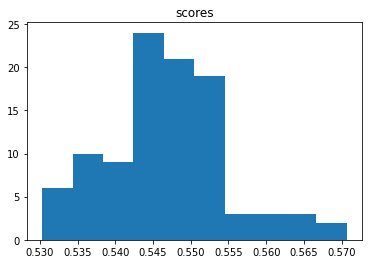

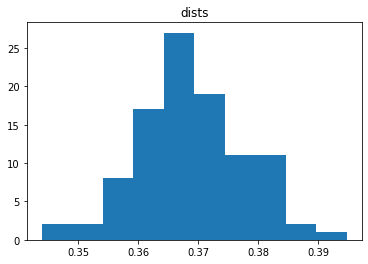

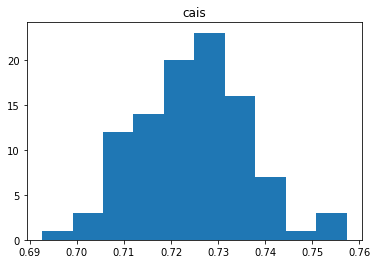

In [93]:
import matplotlib.pyplot as plt

plt.hist(scores)
plt.title('scores')
plt.show()

plt.hist(dists)
plt.title('dists')
plt.show()
plt.hist(cais)
plt.title('cais')
plt.show()

In [155]:
np.argmax(scores)

95

In [154]:
dists[64]

0.272

In [145]:
scipy.spatial.distance.hamming(seqs[1], seqs[2])

1.0

In [140]:
seqs[1]

'ATGGCTATAAAAGGCAAAATAGCAGCTAAGTCTGTCAAGAAAATAAGCAAAGAGGTCGCGCCAAAAACTGACAAGAAAAAGCGGATACATAAGCGTAAGGAGTCTTACGGCATATATATATATAAAGTTCTGCGACAGGTTCATCCTGATACCGGGATATCAGGTAAAGCCATGTCGATAATGAATTCGTTTGTTAACGACGTTTTTGAAAGAATAGCATCGGAGGCAAGTAAATTGGCTACATACAATAAGAAGTCGACAATCACAAGCCGTGAGATCCAAACTGCTGTCCGTCTCATACTTCCCGGTGAACTAGCGAAGCATGCGGTTAGCGAAGGAACAAAGGCCGTTACCAAATATACGGGATCGAAATAA'

In [141]:
seqs[2]

'ATGGCCATCAAAGGGAAGATCGCCGCGAAGTCAGTAAAAAAGATAAGTAAAGAAGTGGCACCTAAAACAGACAAGAAGAAACGGATCCATAAGAGAAAGGAGTCTTATGGGATCTATATCTATAAAGTACTGCGTCAAGTGCACCCGGATACAGGTATATCGGGGAAAGCTATGTCTATAATGAACAGTTTCGTTAATGATGTTTTTGAACGTATCGCCAGCGAAGCATCGAAACTCGCAACCTATAATAAAAAGTCCACGATCACCTCGAGGGAGATCCAGACAGCCGTACGCCTCATTTTACCGGGCGAGCTTGCGAAACATGCGGTCTCCGAGGGCACCAAAGCTGTAACTAAATACACTGGCTCTAAATGA'